#### Data science: Direct marketing optimization
##### Task:
Use dummy data to maximize revenue from direct marketing campaigns.
##### Data:                   
For the analysis, several tables are available:                  
1) Social-demographical data (age, gender, tenure in a bank)                 
2) Products owned + actual volumes (current account, saving account, mutual funds, overdraft, credit card, consumer loan)      
3) Inflow/outflow on C/A, aggregated card turnover (monthly average over past 3 months)          
4) For 60 % of clients actual sales + revenues from these are available (training set)                          

##### Conditions:     
> The bank has capacity to contact only 15 pct. of the clients (cca 100 people) with a marketing offer and each client can be targeted only once.Proposed steps:      
1. Create an analytical dataset (both training and targeting sets)                  
2. Develop 3 propensity models (consumer loan, credit card, mutual fund) using training data set                
3. Optimize targeting clients with the direct marketing offer to maximize the revenue 

##### Expected result:                                            
1) Which clients have higher propensity to buy consumer loan?             
2) Which clients have higher propensity to buy credit card?            
3) Which clients have higher propensity to buy mutual fund?              
4) Which clients are to be targeted with which offer? General description.            
5) What would be the expected revenue based on your strategy?             
##### The executive summary of the analysis should not be larger than two pages. Attach the technical report, list of clients to be contacted with which offer, data, algorithms and codes used.

In [1]:
# importing required packages
import pandas as pd
import numpy as np 
from collections import Counter
from sklearn.impute import KNNImputer
import math
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,roc_curve
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,confusion_matrix,roc_auc_score,f1_score, precision_recall_curve,auc
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import eli5
import pickle

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

##### Reading Data Set

In [2]:
# reading the data set
df_demog = pd.read_excel("Data\Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Soc_Dem')
df_prod = pd.read_excel("Data\Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Products_ActBalance')
df_in_out = pd.read_excel("Data\Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Inflow_Outflow')
df_sales = pd.read_excel("Data\Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Sales_Revenues')

In [3]:
df_demog.head(3)

Client Sex  Age  Tenure
0     909   M   21      27
1    1217   M   38     165
2     850   F   49      44

In [4]:
df_prod.head(3)

Client  Count_CA  Count_SA  Count_MF  Count_OVD  Count_CC  Count_CL  \
0       1         1       NaN       NaN        1.0       NaN       NaN   
1       2         1       1.0       NaN        NaN       NaN       NaN   
2       3         1       NaN       1.0        NaN       NaN       NaN   

     ActBal_CA     ActBal_SA   ActBal_MF  ActBal_OVD  ActBal_CC  ActBal_CL  
0  1333.802857           NaN         NaN         0.0        NaN        NaN  
1   110.768571  13326.190357         NaN         NaN        NaN        NaN  
2   482.654643           NaN  107.251786         NaN        NaN        NaN

In [5]:
df_in_out.head(3)

Client   VolumeCred  VolumeCred_CA  TransactionsCred  TransactionsCred_CA  \
0    1017     0.005000       0.005000                 1                    1   
1    1456   364.772143     364.752857                 4                    3   
2     545  2471.719286    2471.719286                14                   14   

     VolumeDeb  VolumeDeb_CA  VolumeDebCash_Card  VolumeDebCashless_Card  \
0   118.046429    118.046429           25.000000               91.796429   
1   774.980000    774.980000           14.285714              497.444286   
2  2190.257143   2190.257143          303.571429              179.082143   

   VolumeDeb_PaymentOrder  TransactionsDeb  TransactionsDeb_CA  \
0                0.000000               12                  12   
1              258.607143               28                  28   
2             1229.428571               23                  23   

   TransactionsDebCash_Card  TransactionsDebCashless_Card  \
0                         2                             9   
1                         1                            20   
2                         3                             5   

   TransactionsDeb_PaymentOrder  
0                             0  
1                             5  
2                            12

In [6]:
df_sales.head(3)

Client  Sale_MF  Sale_CC  Sale_CL  Revenue_MF  Revenue_CC  Revenue_CL
0    1094        0        1        0    0.000000    5.138571      0.0000
1    1484        1        0        1   25.609107    0.000000      8.7225
2      20        0        1        0    0.000000    3.822500      0.0000

##### Data Exploration

In [7]:
# printing shape of provided data set
print("Print shape of Social Demographic data set: ",df_demog.shape)
print("Print shape of Products Owned and their actual volumes data set: ",df_prod.shape)
print("print shape of Inflow and Outflow data set: ",df_in_out.shape)
print("print shape of Train set data set: ",df_sales.shape)

Print shape of Social Demographic data set:  (1615, 4)
Print shape of Products Owned and their actual volumes data set:  (1615, 13)
print shape of Inflow and Outflow data set:  (1587, 15)
print shape of Train set data set:  (969, 7)


we can see that their are 28 clients not present in Inflow and Outflow data set. Before merging these data set we have to drop those clients from Social Demographic and Products Owned data set.

In [8]:
# merging that two data set having same shape
df = pd.merge(df_demog, df_prod, how="left", on=["Client"])
df = pd.merge(df, df_in_out, how="left", on=["Client"])

In [9]:
print("Print shape of combined data set: ",df.shape)

Print shape of combined data set:  (1615, 30)


##### Spliting the data set into Train and Test

In [10]:
df_train = pd.merge(df, df_sales[['Client','Sale_CC','Revenue_CC']], how="inner", on=["Client"])

In [11]:
print("Print shape of combined data set: ",df_train.shape)

Print shape of combined data set:  (969, 32)


In [12]:
df_train.head(3)

Client Sex  Age  Tenure  Count_CA  Count_SA  Count_MF  Count_OVD  Count_CC  \
0    1217   M   38     165         1       NaN       NaN        NaN       NaN   
1     850   F   49      44         1       NaN       NaN        NaN       NaN   
2    1473   M   54      34         1       1.0       NaN        NaN       1.0   

   Count_CL    ActBal_CA     ActBal_SA  ActBal_MF  ActBal_OVD  ActBal_CC  \
0       NaN  6752.244643           NaN        NaN         NaN        NaN   
1       NaN    43.523214           NaN        NaN         NaN        NaN   
2       1.0    29.024286  14447.801429        NaN         NaN     653.91   

     ActBal_CL   VolumeCred  VolumeCred_CA  TransactionsCred  \
0          NaN     0.002143       0.002143               1.0   
1          NaN  1392.402857    1392.402857               3.0   
2  1132.590357  1787.127500     939.128929              14.0   

   TransactionsCred_CA    VolumeDeb  VolumeDeb_CA  VolumeDebCash_Card  \
0                  1.0   714.285714    714.285714            0.000000   
1                  3.0  1226.345357   1226.345357            0.000000   
2                  5.0  3875.137857   3794.580714          357.142857   

   VolumeDebCashless_Card  VolumeDeb_PaymentOrder  TransactionsDeb  \
0                  0.0000              714.285714              1.0   
1                  0.0000              121.928571              6.0   
2                444.5975             2076.785714             48.0   

   TransactionsDeb_CA  TransactionsDebCash_Card  TransactionsDebCashless_Card  \
0                 1.0                       0.0                           0.0   
1                 6.0                       0.0                           0.0   
2                38.0                       1.0                          26.0   

   TransactionsDeb_PaymentOrder  Sale_CC  Revenue_CC  
0                           1.0        0    0.000000  
1                           1.0        1    0.893929  
2                          11.0        0    0.000000

we can see that most of columns are having very big range and few are having small values so before applying our models to the data set we have to do the scaling of the data set.

##### Data Pre-Processing

In [13]:
# columns which are not required for sale of Consumer loan prediction
# columns_sale_cl = ['Count_MF','Count_CC','ActBal_MF','ActBal_CC']
columns_sale_cl = ['Count_CC','ActBal_CC']
df_train.drop(columns_sale_cl,inplace = True,axis = 1)

In [14]:
# finding total number of duplicate values in data set if any
print('Total number of duplicate values in the data set is/are: {}'.format(df_train.duplicated().sum()))

Total number of duplicate values in the data set is/are: 0


There are no duplicate rows in the data set

In [15]:
# checking types of the columns in the data set
df_train.dtypes

Client                            int64
Sex                              object
Age                               int64
Tenure                            int64
Count_CA                          int64
Count_SA                        float64
Count_MF                        float64
Count_OVD                       float64
Count_CL                        float64
ActBal_CA                       float64
ActBal_SA                       float64
ActBal_MF                       float64
ActBal_OVD                      float64
ActBal_CL                       float64
VolumeCred                      float64
VolumeCred_CA                   float64
TransactionsCred                float64
TransactionsCred_CA             float64
VolumeDeb                       float64
VolumeDeb_CA                    float64
VolumeDebCash_Card              float64
VolumeDebCashless_Card          float64
VolumeDeb_PaymentOrder          float64
TransactionsDeb                 float64
TransactionsDeb_CA              float64


In [16]:
# checking for null values in the data set
col = df_train.columns
for i in col:
    # count number of rows with missing values
    n_miss = df_train[[i]].isnull().sum()
    perc = n_miss / df_train.shape[0] * 100
    print('%s, Missing: %d (%.1f%%)' % (i, n_miss, perc))

Client, Missing: 0 (0.0%)
Sex, Missing: 2 (0.2%)
Age, Missing: 0 (0.0%)
Tenure, Missing: 0 (0.0%)
Count_CA, Missing: 0 (0.0%)
Count_SA, Missing: 704 (72.7%)
Count_MF, Missing: 785 (81.0%)
Count_OVD, Missing: 718 (74.1%)
Count_CL, Missing: 890 (91.8%)
ActBal_CA, Missing: 0 (0.0%)
ActBal_SA, Missing: 704 (72.7%)
ActBal_MF, Missing: 785 (81.0%)
ActBal_OVD, Missing: 718 (74.1%)
ActBal_CL, Missing: 890 (91.8%)
VolumeCred, Missing: 18 (1.9%)
VolumeCred_CA, Missing: 18 (1.9%)
TransactionsCred, Missing: 18 (1.9%)
TransactionsCred_CA, Missing: 18 (1.9%)
VolumeDeb, Missing: 18 (1.9%)
VolumeDeb_CA, Missing: 18 (1.9%)
VolumeDebCash_Card, Missing: 18 (1.9%)
VolumeDebCashless_Card, Missing: 18 (1.9%)
VolumeDeb_PaymentOrder, Missing: 18 (1.9%)
TransactionsDeb, Missing: 18 (1.9%)
TransactionsDeb_CA, Missing: 18 (1.9%)
TransactionsDebCash_Card, Missing: 18 (1.9%)
TransactionsDebCashless_Card, Missing: 18 (1.9%)
TransactionsDeb_PaymentOrder, Missing: 18 (1.9%)
Sale_CC, Missing: 0 (0.0%)
Revenue_CC, Miss

We can see that their are lot of missing values in the data set. Before applying any algorithm we have to either impute the values or drop the values.    
1) For sex we have two rows missing so I will impute it with U (Unknown) considering that client might not want to reveal their gender.   
2) For features from Inflow Outflow data set, having 18 rows missing in all of the feature we will impute it with 0 considering that client is in active in past 3 months.        
3) For feature from Product Owned data set we have almost 70-90% data set missing in all features. I think the feature might add value to our model so I will impute this also with 0 considering that client don't avail these features from the bank.    

We are not using mean or median imputation because it ignores the feature correlation and will also reduce the variance. Since the data set is very small, smaller variance leads to the narrower confidence interval in the probability distribution. This will lead to bias to our model.    

In [17]:
# replacing nan values of Sex field with U- Unknown
# df_train.dropna(subset = ["Sex"], inplace=True)

df_train.Sex = df_train.Sex.replace(np.nan,"U",regex=True)

In [18]:
# We have to convert Sex from object to numeric type
# df_train.Sex.unique()

# converting M and F to 1 and 0
df_train.Sex = df_train.Sex.replace({'M':1, 'F':0,'U':2})

In [19]:
# imputing with KNNImputer
# col_mean = ['VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA',
#            'VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','TransactionsDeb','TransactionsDeb_CA'
#            ,'TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
# k = math.sqrt(df_train.shape[0])
# imputer = KNNImputer(n_neighbors=100, weights='uniform', metric='nan_euclidean')
# df_train = imputer.fit_transform(df_train)

In [20]:
df_train.describe().T

count          mean           std        min  \
Client                        969.0    814.781218    464.568139   1.000000   
Sex                           969.0      0.535604      0.503112   0.000000   
Age                           969.0     42.983488     18.578951   0.000000   
Tenure                        969.0    100.393189     65.437097   0.000000   
Count_CA                      969.0      1.075335      0.323815   1.000000   
Count_SA                      265.0      1.181132      0.457702   1.000000   
Count_MF                      184.0      5.179348      9.354897   1.000000   
Count_OVD                     251.0      1.000000      0.000000   1.000000   
Count_CL                       79.0      1.113924      0.319749   1.000000   
ActBal_CA                     969.0   2493.026329   6268.027982   0.000000   
ActBal_SA                     265.0  14427.773550  32615.370810   0.000000   
ActBal_MF                     184.0  21250.471671  77683.063992   0.000000   
ActBal_OVD                    251.0    147.294607    323.162968   0.000000   
ActBal_CL                      79.0   3952.655140   3888.046341  63.803214   
VolumeCred                    951.0   1832.384099   6211.583270   0.000000   
VolumeCred_CA                 951.0   1482.160302   4810.626815   0.000000   
TransactionsCred              951.0      5.650894      6.405269   0.000000   
TransactionsCred_CA           951.0      4.296530      4.920246   0.000000   
VolumeDeb                     951.0   1704.602524   4636.907178   0.000000   
VolumeDeb_CA                  951.0   1504.248163   4371.419774   0.000000   
VolumeDebCash_Card            951.0    270.893490    873.632946   0.000000   
VolumeDebCashless_Card        951.0    157.730155    333.325850   0.000000   
VolumeDeb_PaymentOrder        951.0    719.346524   3097.920573   0.000000   
TransactionsDeb               951.0     16.365931     16.367897   0.000000   
TransactionsDeb_CA            951.0     13.821241     13.003061   0.000000   
TransactionsDebCash_Card      951.0      2.018927      2.709760   0.000000   
TransactionsDebCashless_Card  951.0      5.360673      8.376615   0.000000   
TransactionsDeb_PaymentOrder  951.0      4.629863      5.236684   0.000000   
Sale_CC                       969.0      0.249742      0.433087   0.000000   
Revenue_CC                    969.0      2.712827     17.693433   0.000000   

                                      25%          50%           75%  \
Client                         422.000000   819.000000   1216.000000   
Sex                              0.000000     1.000000      1.000000   
Age                             29.000000    41.000000     57.000000   
Tenure                          42.000000    95.000000    151.000000   
Count_CA                         1.000000     1.000000      1.000000   
Count_SA                         1.000000     1.000000      1.000000   
Count_MF                         1.000000     2.000000      5.000000   
Count_OVD                        1.000000     1.000000      1.000000   
Count_CL                         1.000000     1.000000      1.000000   
ActBal_CA                       73.135000   536.951429   2262.178929   
ActBal_SA                      725.631429  4352.067857  13326.190357   
ActBal_MF                        0.000000  1953.776429  11241.016339   
ActBal_OVD                       0.000000     0.000000    122.903393   
ActBal_CL                     1085.637679  2906.981786   5315.682321   
VolumeCred                     269.733571   659.253929   1450.771607   
VolumeCred_CA                  230.809643   634.432857   1317.899821   
TransactionsCred                 2.000000     4.000000      6.000000   
TransactionsCred_CA              2.000000     3.000000      4.000000   
VolumeDeb                      240.738750   691.642857   1453.959821   
VolumeDeb_CA                   220.428571   667.607143   1337.509286   
VolumeDebCash_Card               0.000000    89.285714    357.142857   
VolumeDebCashless_Card     

we can see that minimum value for age is zero that means age column is having some erroneous values, we have to analyse age column and see how we can either impute values or if can't impute than drop the rows.

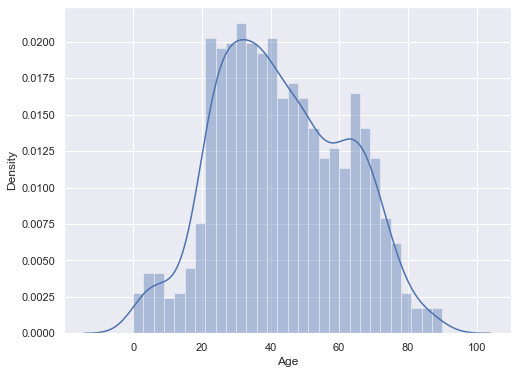

In [21]:
# density plot with tenure of customer with bank
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,6)})
sns.distplot(df_train.Age, bins=30);

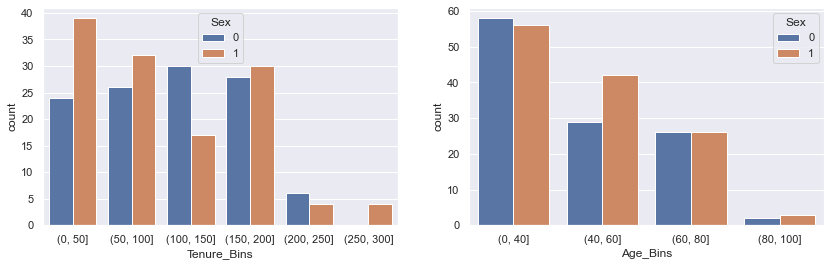

In [109]:
# Ploting Sale for age and Tenure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
df_train['Tenure_Bins'] = pd.cut(df_train['Tenure'], bins = [0,50,100,150,200,250,300])
df_train['Age_Bins'] = pd.cut(df_train['Age'], bins = [0,40,60,80,100])
sns.countplot(df_train[df_train['Sale_CC']==1]['Tenure_Bins'], hue=df_train[df_train['Sale_CC']==1]["Sex"] ,ax=ax1);
sns.countplot(df_train[df_train['Sale_CC']==1]['Age_Bins'], hue=df_train[df_train['Sale_CC']==1]["Sex"], ax=ax2);
df_train.drop(labels=['Tenure_Bins','Age_Bins'], axis=1, inplace=True)

In [23]:
# Checking age of customer where age is less than the tenure with the bank
df_train.query('Age*12 <=Tenure')

Client  Sex  Age  Tenure  Count_CA  Count_SA  Count_MF  Count_OVD  \
4       225    1   14     187         1       NaN       NaN        1.0   
6      1231    0    6     232         1       NaN       NaN        NaN   
11      316    0    1     211         1       NaN       NaN        NaN   
16     1160    1   19     260         1       NaN       NaN        1.0   
24      682    0    3     149         1       1.0      11.0        NaN   
100     322    0    1      92         1       1.0       NaN        NaN   
124    1499    0    5     267         1       NaN       NaN        1.0   
138    1561    1   12     204         1       1.0       NaN        NaN   
143     638    1    1      31         1       NaN       NaN        1.0   
203    1431    0   19     231         1       NaN       NaN        NaN   
217    1372    1   10     176         1       1.0       NaN        NaN   
273    1256    1    6     149         1       NaN       NaN        1.0   
295     391    1    1      16         1       NaN       NaN        NaN   
303      23    1    4     160         1       2.0       4.0        1.0   
306    1529    0    1      36         1       1.0       NaN        NaN   
358     672    1    4     261         1       NaN       NaN        NaN   
419     544    1    5     113         1       NaN      64.0        NaN   
447    1056    0   10     159         1       NaN       NaN        NaN   
564     859    1   12     150         1       NaN       NaN        NaN   
576    1583    1    8     151         1       NaN       NaN        NaN   
600    1591    0   10     170         1       NaN       NaN        1.0   
603    1169    0    6     172         1       NaN       NaN        NaN   
640    1409    0   10     149         1       NaN       NaN        1.0   
719     509    1    5     168         1       NaN       NaN        1.0   
728     158    1    0     152         1       1.0       NaN        NaN   
782     613    0    5      96         1       NaN       NaN        1.0   
783    1403    0    4     151         1       1.0       8.0        NaN   
823    1427    0    4     179         1       1.0       NaN        NaN   
828     961    0    8     154         1       NaN       NaN        NaN   
831     856    0    5      62         1       NaN       1.0        NaN   
875    1044    0    2      70         1       2.0       1.0        NaN   
903     300    0    5      87         1       NaN       NaN        NaN   
932     648    0    7     152         1       1.0       NaN        NaN   
936    1615    1    7     180         2       1.0       NaN        1.0   

     Count_CL    ActBal_CA      ActBal_SA     ActBal_MF  ActBal_OVD  \
4         NaN   345.686071            NaN           NaN  618.397500   
6         NaN   819.853929            NaN           NaN         NaN   
11        NaN    22.733571            NaN           NaN         NaN   
16        1.0  2723.980357            NaN           NaN    0.000000   
24        NaN   684.281429    4557.607500   1146.417500         NaN   
100       NaN  2175.270000  128617.591071           NaN         NaN   
124       1.0     0.000000            NaN           NaN  127.357143   
138       NaN   361.470357    1927.531786           NaN         NaN   
143       NaN    89.250000            NaN           NaN    0.000000   
203       NaN  1046.317143            NaN           NaN         NaN   
217       NaN   224.758214     549.039286           NaN         NaN   
273       NaN   237.148571            NaN           NaN    0.000000   
295       1.0   172.581429            NaN           NaN         NaN   
303       NaN    22.967143   25325.437857    868.703571  333.400714   
306       NaN   742.263571   85471.000714           NaN         NaN   
358       NaN    47.964643            NaN           NaN         NaN   
419       NaN  4808.271071            NaN  32990.446071         NaN   
447       NaN   283.605000            NaN           NaN         NaN   
564       NaN   359.033214            NaN           NaN         N

We can see that their are 34 rows where age less than the tenure with the bank so we assume that either data in age or tenure is incorrect. But after carefuly considering both the columns we can see that in some case age is even less than 10 years and the client is holding a current account with the bank. So we can say that values in age is wrong.    

##### Assumption     
1) we assume that to have a bank account with bank client must be atleast of 10 years. Since, even to have a student account the student must be atleast 10 years.      
2) To impute the age we will add 10 years with tenure of the client.

In [24]:
# imputing age with tenure + 120 months 
df_train.Age = np.where((df_train.Age *12 <= df_train.Tenure),round(df_train.Tenure/12) + 10,df_train.Age)

In [25]:
# imputing other values with 0 in the data set
df_train.fillna(0,inplace = True)

In [26]:
df_train.isnull().sum()

Client                          0
Sex                             0
Age                             0
Tenure                          0
Count_CA                        0
Count_SA                        0
Count_MF                        0
Count_OVD                       0
Count_CL                        0
ActBal_CA                       0
ActBal_SA                       0
ActBal_MF                       0
ActBal_OVD                      0
ActBal_CL                       0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDeb_PaymentOrder    0
Sale_CC                         0
Revenue_CC    

In [27]:
# statistical analysis of the data set
df_train.describe().T

count         mean           std  min  \
Client                        969.0   814.781218    464.568139  1.0   
Sex                           969.0     0.535604      0.503112  0.0   
Age                           969.0    43.552116     17.683560  2.0   
Tenure                        969.0   100.393189     65.437097  0.0   
Count_CA                      969.0     1.075335      0.323815  1.0   
Count_SA                      969.0     0.323013      0.578450  0.0   
Count_MF                      969.0     0.983488      4.547015  0.0   
Count_OVD                     969.0     0.259030      0.438328  0.0   
Count_CL                      969.0     0.090815      0.318195  0.0   
ActBal_CA                     969.0  2493.026329   6268.027982  0.0   
ActBal_SA                     969.0  3945.675945  18207.655212  0.0   
ActBal_MF                     969.0  4035.177283  34790.633952  0.0   
ActBal_OVD                    969.0    38.153711    176.465581  0.0   
ActBal_CL                     969.0   322.249490   1545.704566  0.0   
VolumeCred                    969.0  1798.346004   6158.536798  0.0   
VolumeCred_CA                 969.0  1454.627912   4769.894363  0.0   
TransactionsCred              969.0     5.545924      6.391191  0.0   
TransactionsCred_CA           969.0     4.216718      4.908721  0.0   
VolumeDeb                     969.0  1672.938081   4599.361399  0.0   
VolumeDeb_CA                  969.0  1476.305473   4335.350848  0.0   
VolumeDebCash_Card            969.0   265.861413    866.245556  0.0   
VolumeDebCashless_Card        969.0   154.800184    330.898970  0.0   
VolumeDeb_PaymentOrder        969.0   705.984050   3070.520579  0.0   
TransactionsDeb               969.0    16.061920     16.365034  0.0   
TransactionsDeb_CA            969.0    13.564499     13.016210  0.0   
TransactionsDebCash_Card      969.0     1.981424      2.698267  0.0   
TransactionsDebCashless_Card  969.0     5.261094      8.329906  0.0   
TransactionsDeb_PaymentOrder  969.0     4.543860      5.225334  0.0   
Sale_CC                       969.0     0.249742      0.433087  0.0   
Revenue_CC                    969.0     2.712827     17.693433  0.0   

                                     25%         50%          75%  \
Client                        422.000000  819.000000  1216.000000   
Sex                             0.000000    1.000000     1.000000   
Age                            29.000000   41.000000    57.000000   
Tenure                         42.000000   95.000000   151.000000   
Count_CA                        1.000000    1.000000     1.000000   
Count_SA                        0.000000    0.000000     1.000000   
Count_MF                        0.000000    0.000000     0.000000   
Count_OVD                       0.000000    0.000000     1.000000   
Count_CL                        0.000000    0.000000     0.000000   
ActBal_CA                      73.135000  536.951429  2262.178929   
ActBal_SA                       0.000000    0.000000     0.395714   
ActBal_MF                       0.000000    0.000000     0.000000   
ActBal_OVD                      0.000000    0.000000     0.000000   
ActBal_CL                       0.000000    0.000000     0.000000   
VolumeCred                    223.572500  645.252143  1437.008929   
VolumeCred_CA                 198.960714  619.927143  1297.770000   
TransactionsCred                2.000000    3.000000     6.000000   
TransactionsCred_CA             2.000000    3.000000     4.000000   
VolumeDeb                     205.714286  671.896429  1421.702143   
VolumeDeb_CA                  189.160714  643.403571  1324.642857   
VolumeDebCash_Card              0.000000   74.281429   353.571429   
VolumeDebCashless_Card          0.000000   23.820357   181.307143   
VolumeDeb_PaymentOrder          0.000000  171.964286   483.178571   
TransactionsDeb                 4.000000   12.000000    22.000000   
TransactionsDeb_CA              4.000000   10.000000    19.000000   
TransactionsDebCash_Card        0.

Still we can see some clients having age less than 10 years so now we will impute these with KNNImputer considering these vales are missing at random.    

In [28]:
# # imputing with KNNImputer
# k = math.sqrt(df_train.shape[0])
# imputer = KNNImputer(n_neighbors=round(k), weights='uniform', metric='nan_euclidean')
# # df_train.Age = df_train.Age.replace('Age<=10',np.nan,regex=True)
# df_train.Age = df_train.Age.mask(df_train.Age <= 10)
# df_train[col] = imputer.fit_transform(df_train.values)
# # df_train.Age = np.where((df_train.Age *12 <= df_train.Tenure),imputer.fit_transform(df_train.Age.value),df_train.Age)

In [29]:
# #creating a pickle of KNNImputer to use it for our recomendations
# pickle.dump(imputer, open('KNNImputer_CC.pkl', 'wb'))

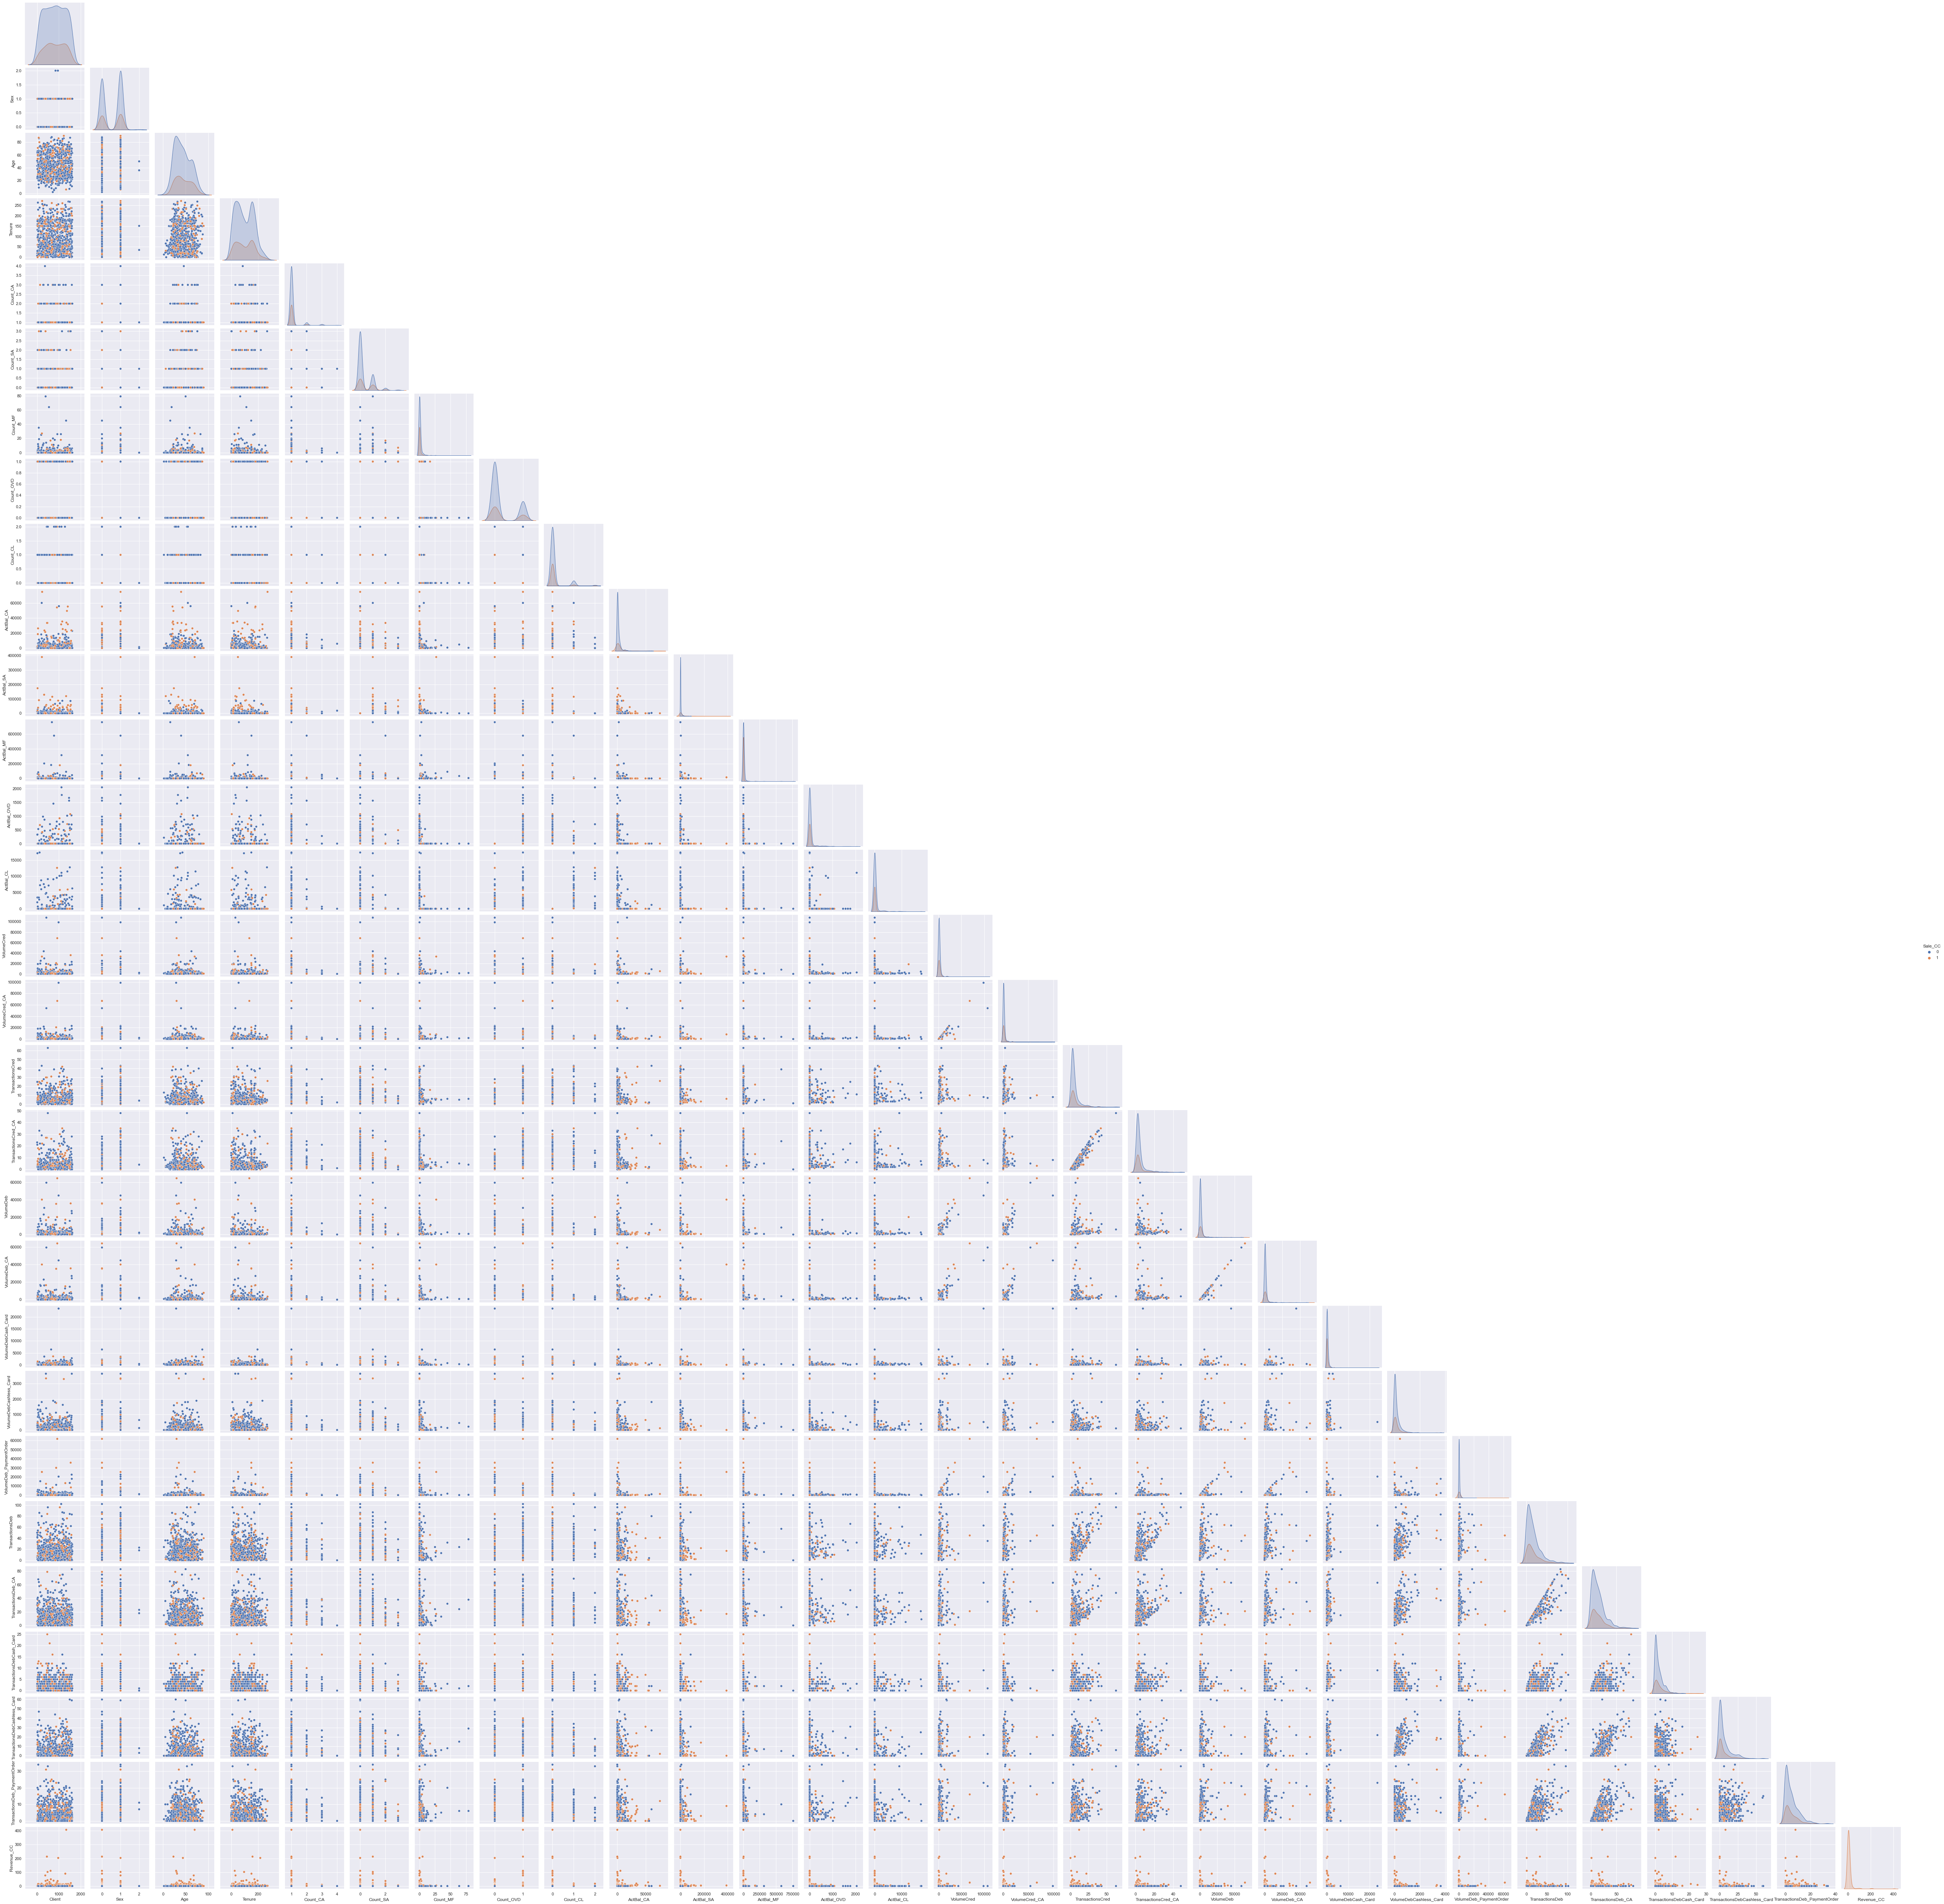

In [30]:
sns.pairplot(df_train[col], hue='Sale_CC', corner=True);

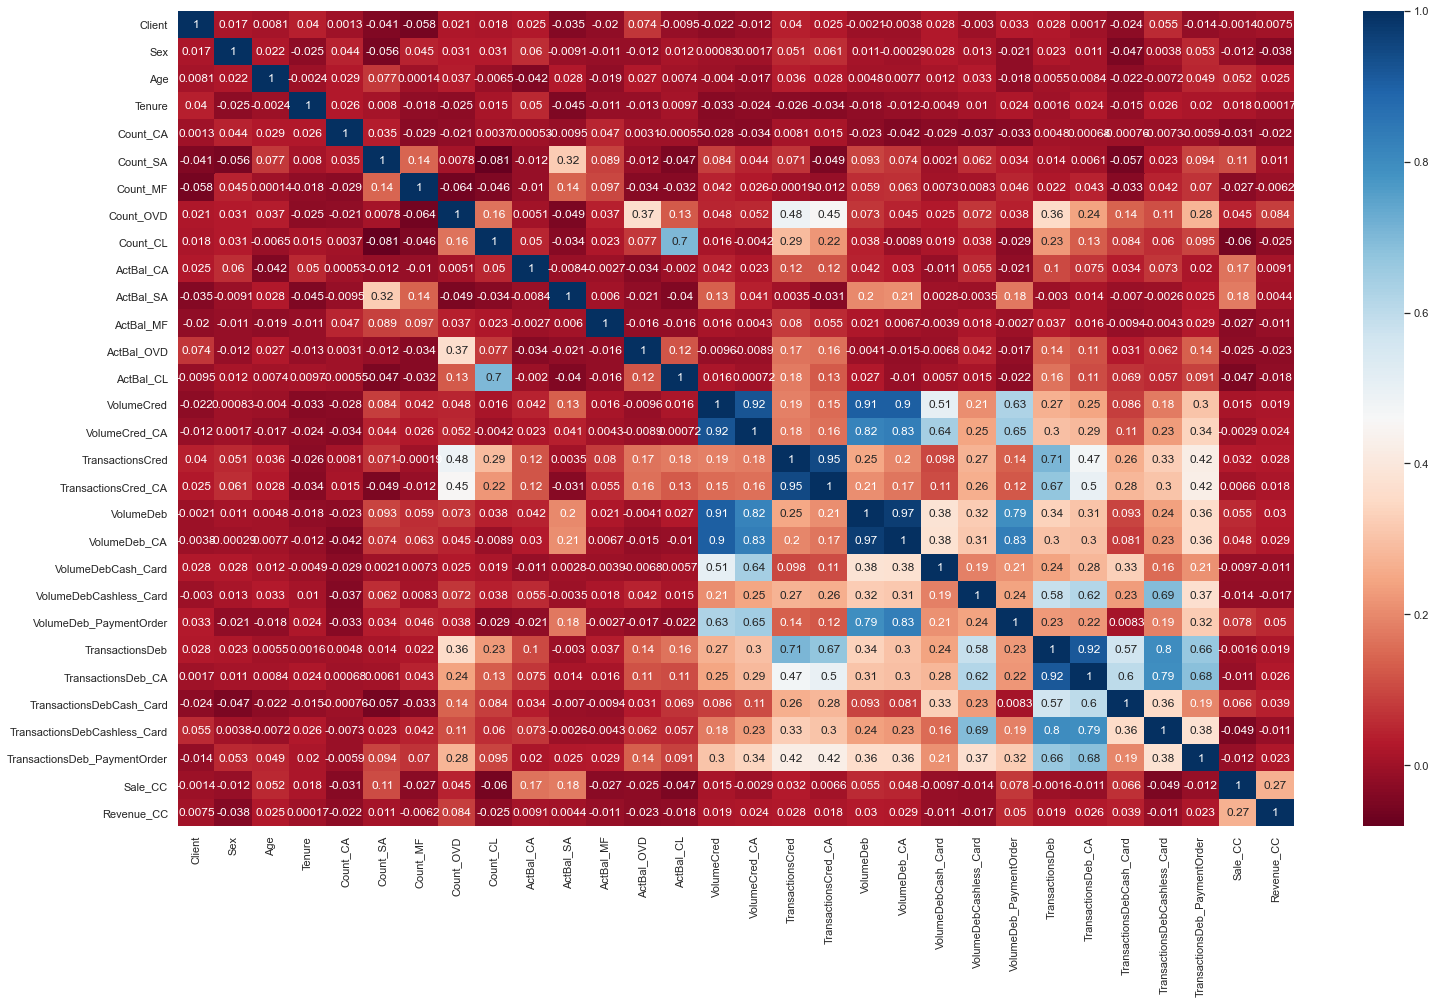

In [31]:
# Checking for multicollinearity

plt.figure(figsize=(25,15))
sns.heatmap(df_train.corr(),cmap='RdBu',annot=True);

There is some corelation between the features, but we will use different algorithms which can handle these corelation. Other option is to drop the features which are having high corelation.

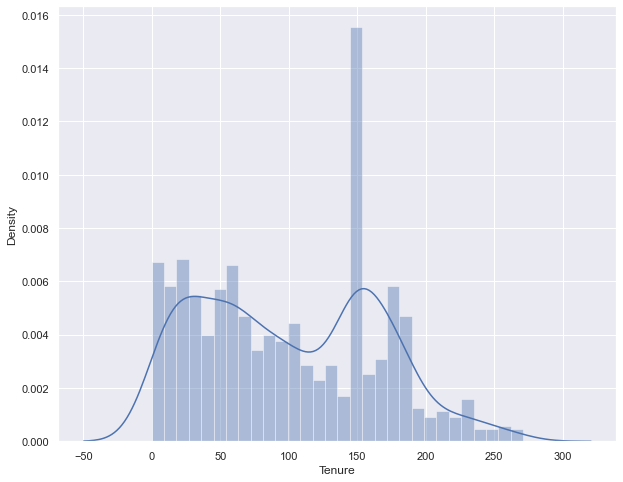

In [32]:
# density plot with tenure of customer with bank
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(df_train.Tenure, bins=30);

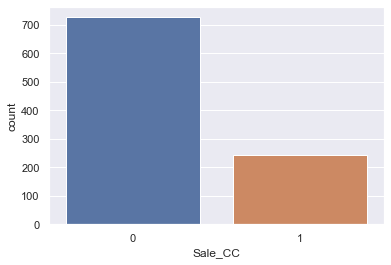

In [33]:
sns.set(rc={'figure.figsize':(6,4)})
sns.countplot(df_train.Sale_CC);

Their is clear imbalance in the data set we have to handle this also while applying our machine learning algorithm.
Two ways by which we can handle this class imbalance problem:    
1) By adjusting the class weight while training    
2) By over/under sampling of the data set    

In [34]:
#Splitting data set into train and test
# deviding the data set into target and predictors
X = df_train.copy()
X.drop(['Client','Sale_CC','Revenue_CC'],inplace = True, axis = 1)
y_sale_cc = df_train.iloc[:,28].values
y_revenue_cc = df_train.iloc[:,29].values
X_train, X_test, y_train, y_test = train_test_split(X, y_sale_cc, test_size=0.2, stratify=y_sale_cc, random_state=1)


In [35]:
# imputing with KNNImputer
col_train = X_train.columns
k = math.sqrt(X_train.shape[0])
imputer = KNNImputer(n_neighbors=round(k), weights='uniform', metric='nan_euclidean')
# df_train.Age = df_train.Age.replace('Age<=10',np.nan,regex=True)
X_train.Age = X_train.Age.mask(X_train.Age <= 10)
X_train[col_train] = imputer.fit_transform(X_train.values)
# df_train.Age = np.where((df_train.Age *12 <= df_train.Tenure),imputer.fit_transform(df_train.Age.value),df_train.Age)

In [36]:
X_test.Age = X_test.Age.mask(X_test.Age <= 10)
X_test[col_train] = imputer.transform(X_test.values)

In [37]:
#creating a pickle of KNNImputer to use it for our recomendations
pickle.dump(imputer, open('KNNImputer_MF.pkl', 'wb'))

##### Machine learning Models

Applying ML classification models for predicting sale of consumer loan

I will be creating a function for model evaluation so that I don't have to write the same code again and again and will be evaluating the model based on different metrics. Based on this evaluation I will decide which algorithm needs parameter tunning and can be improved.

In [38]:
def model_evaluation(model,scale = False, classification = False):
    if classification == True:
        scoring = [    'precision', 
                       'recall',
                       'f1', 
                       'accuracy']
    else:
        scoring = [    
                       'neg_mean_squared_error',
                       'neg_mean_absolute_error',
                       'neg_root_mean_squared_error'
                       ]
    # Declaring parameters
    R_STATE = 1
    over = RandomOverSampler(sampling_strategy=0.3,random_state = 1)
    under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
    if scale == True :
        Steps = [
        #             ('i', KNNImputer(n_neighbors=31)),
    #                 ('ov',over),
    #                 ('un',under),
                    ('minmaxscaler',MinMaxScaler(feature_range=(0, 1))),
                    ('m', model)
                ]
    else:
        Steps = [
            #             ('i', KNNImputer(n_neighbors=31)),
#                         ('ov',over),
#                         ('un',under),
                        ('m', model)
                    ]
    pipeline = Pipeline(steps=Steps)
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    if classification == True:
        scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
        # store results
        score_df = pd.DataFrame(scores)
    else:
        scores = cross_validate(pipeline, X_train_reg, y_train_reg, scoring=scoring, cv=10, n_jobs=-1)
        # store results
        score_df = pd.DataFrame(scores)
    return score_df

In [39]:
print("Model Evaluation for Ada Boost Algorithm")
model_evaluation(AdaBoostClassifier(),scale = False,classification=True)

Model Evaluation for Ada Boost Algorithm


fit_time  score_time  test_precision  test_recall   test_f1  test_accuracy
0  0.132032    0.011001        0.400000     0.210526  0.275862       0.729032
1  0.126029    0.011001        0.631579     0.307692  0.413793       0.780645
2  0.131028    0.013005        0.571429     0.307692  0.400000       0.767742
3  0.132167    0.012006        0.500000     0.179487  0.264151       0.748387
4  0.132171    0.013003        0.666667     0.256410  0.370370       0.780645
5  0.129031    0.011144        0.562500     0.236842  0.333333       0.767742
6  0.132171    0.012003        0.352941     0.153846  0.214286       0.716129
7  0.127167    0.011004        0.611111     0.282051  0.385965       0.774194
8  0.124169    0.011003        0.545455     0.153846  0.240000       0.754839
9  0.126170    0.013003        0.588235     0.256410  0.357143       0.767742

In [40]:
print("Model Evaluation XGBoost Algorithm")
model_evaluation(XGBClassifier(),scale = False,classification=True)

Model Evaluation XGBoost Algorithm


fit_time  score_time  test_precision  test_recall   test_f1  test_accuracy
0  0.518448    0.009204        0.304348     0.184211  0.229508       0.696774
1  0.424294    0.007001        0.368421     0.179487  0.241379       0.716129
2  0.501777    0.009001        0.320000     0.205128  0.250000       0.690323
3  0.425295    0.008001        0.437500     0.179487  0.254545       0.735484
4  0.181446    0.008004        0.500000     0.230769  0.315789       0.748387
5  0.557355    0.009126        0.407407     0.289474  0.338462       0.722581
6  2.748814    0.009069        0.318182     0.179487  0.229508       0.696774
7  2.744815    0.007069        0.480000     0.307692  0.375000       0.741935
8  2.735810    0.008070        0.400000     0.205128  0.271186       0.722581
9  2.740854    0.009030        0.600000     0.307692  0.406780       0.774194

In [41]:
print("Model Evaluation Random Forest Classifier Algorithm")
model_evaluation(RandomForestClassifier(),scale = False,classification=True)

Model Evaluation Random Forest Classifier Algorithm


fit_time  score_time  test_precision  test_recall   test_f1  test_accuracy
0  0.274398    0.016112        0.636364     0.184211  0.285714       0.774194
1  0.271400    0.017111        0.750000     0.230769  0.352941       0.787097
2  0.287510    0.014347        0.400000     0.102564  0.163265       0.735484
3  0.285506    0.014349        0.461538     0.153846  0.230769       0.741935
4  0.292849    0.012051        0.750000     0.153846  0.255319       0.774194
5  0.303902    0.012770        0.538462     0.184211  0.274510       0.761290
6  0.292901    0.018766        0.500000     0.128205  0.204082       0.748387
7  0.280729    0.010787        0.600000     0.230769  0.333333       0.767742
8  0.273668    0.013819        0.600000     0.153846  0.244898       0.761290
9  0.283339    0.013038        0.900000     0.230769  0.367347       0.800000

In [42]:
print("Model Evaluation Logistic Regression Algorithm")
model_evaluation(LogisticRegression(class_weight={0:0.3,1:0.7}),scale = True,classification=True)

Model Evaluation Logistic Regression Algorithm


fit_time  score_time  test_precision  test_recall   test_f1  test_accuracy
0  0.010110    0.006187        0.440000     0.289474  0.349206       0.735484
1  0.012296    0.005999        0.611111     0.282051  0.385965       0.774194
2  0.012294    0.005001        0.434783     0.256410  0.322581       0.729032
3  0.013255    0.005998        0.421053     0.205128  0.275862       0.729032
4  0.019253    0.005000        0.588235     0.256410  0.357143       0.767742
5  0.014240    0.006001        0.428571     0.315789  0.363636       0.729032
6  0.013238    0.004001        0.375000     0.230769  0.285714       0.709677
7  0.013235    0.005000        0.666667     0.256410  0.370370       0.780645
8  0.015186    0.005008        0.454545     0.256410  0.327869       0.735484
9  0.013003    0.003998        0.454545     0.256410  0.327869       0.735484

In [43]:
# print("Model Evaluation Naive Bayes Algorithm")
# model_evaluation(MultinomialNB(),scale = True,classification=True)

After validating all the models we can see that AdaBoost and Logistic regression performed well with the given data set so we will perform hyperparameter tunning to see if we can improve the model performance

##### AdaBoost Classifier

In [44]:
# creating a parameter grid for cross validation and hyper parameter tuning

cv_abc = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
param_grid_abc = {'m__n_estimators':[70,100,150],
              'm__learning_rate':[1.0,0.5,1.5]
               
#               'm__class_weight':[{0:0.1,1:0.9},{0:0.20,1:0.80},'balanced']
#               'm__solver':['lbfgs','saga','liblinear']
              
}
model = AdaBoostClassifier()
Steps_abc = [('m', model)]
pipeline_abc = Pipeline(steps = Steps_abc)
grid_search_abc = GridSearchCV(estimator = pipeline_abc, param_grid = param_grid_abc,refit = 'precision',scoring = ['precision','recall'], cv = cv_abc, n_jobs = -1, verbose = 2)

In [45]:
grid_search_abc.fit(X_train, y_train)
grid_search_abc.best_params_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


{'m__learning_rate': 0.5, 'm__n_estimators': 70}

In [46]:
model_abc = grid_search_abc.best_estimator_

In [47]:
# predicting the values using X_test data set
y_pred_abc = model_abc.predict(X_test)

In [48]:
print(classification_report(y_test,y_pred_abc))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       146
           1       0.70      0.15      0.24        48

    accuracy                           0.77       194
   macro avg       0.74      0.56      0.55       194
weighted avg       0.76      0.77      0.71       194



In [49]:
confusion_matrix(y_test,y_pred_abc)

array([[143,   3],
       [ 41,   7]], dtype=int64)

ROC AUC: 0.513


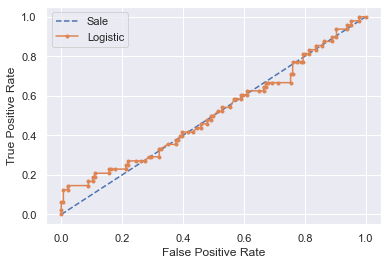

In [50]:
# ROC curve

# predict probabilities
yhat_roc = model_abc.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs_roc = yhat_roc[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='Sale')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs_roc)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
roc_auc = roc_auc_score(y_test, pos_probs_roc)
print('ROC AUC: %.3f' % roc_auc)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

##### Logistic Regression Alogorithm

In [51]:
# creating grid for Logistic regression
cv_lr = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
param_grid_lr = {'m__max_iter':[40,70,100],
              'm__penalty':['l1','l2','elasticnet'],
              'm__class_weight':[{0:0.35,1:0.65},{0:0.40,1:0.60},'balanced']
#               'm__solver':['lbfgs','saga','liblinear']
                }
model = LogisticRegression()
Steps_lr = [
            ('msc',MinMaxScaler(feature_range=(0, 1))),
#             ('sc',StandardScaler()),
            ('m', model)
]
pipeline_lr = Pipeline(steps = Steps_lr)
grid_search_lr = GridSearchCV(estimator = pipeline_lr, param_grid = param_grid_lr,refit = 'precision',scoring = ['precision','recall'], cv = cv_lr, n_jobs = -1, verbose = 2)                 

In [52]:
grid_search_lr.fit(X_train, y_train)
grid_search_lr.best_params_

Fitting 10 folds for each of 27 candidates, totalling 270 fits


{'m__class_weight': {0: 0.35, 1: 0.65}, 'm__max_iter': 40, 'm__penalty': 'l2'}

In [53]:
model_lr = grid_search_lr.best_estimator_

In [54]:
# predicting the values using X_test data set
y_pred_lr = model_lr.predict(X_test)

In [55]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       146
           1       0.64      0.15      0.24        48

    accuracy                           0.77       194
   macro avg       0.71      0.56      0.55       194
weighted avg       0.74      0.77      0.71       194



In [56]:
confusion_matrix(y_test,y_pred_lr)

array([[142,   4],
       [ 41,   7]], dtype=int64)

ROC AUC: 0.665


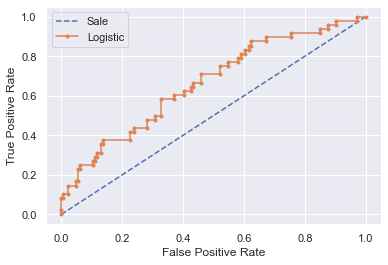

In [57]:
# ROC curve

# predict probabilities
yhat_roc = model_lr.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs_roc = yhat_roc[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='Sale')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs_roc)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
roc_auc = roc_auc_score(y_test, pos_probs_roc)
print('ROC AUC: %.3f' % roc_auc)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [58]:
# # Precision-Recall Curve

# # predict probabilities
# yhat = model_lr.predict_proba(X_test)
# # retrieve just the probabilities for the positive class
# pos_probs = yhat[:, 1]
# sale = len(y_train[y_train==1]) / len(y_train)
# plt.plot([0, 1], [sale, sale], linestyle='--', label='Sale')
# # calculate model precision-recall curve
# precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# auc_score = auc(recall, precision)
# print('PR AUC: %.3f' % auc_score)
# # plot the model precision-recall curve
# plt.plot(recall, precision, marker='.', label='LR')
# # axis labels
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()

Feature: Sex, Score: 0.04222
Feature: Age, Score: 0.14494
Feature: Tenure, Score: 0.20010
Feature: Count_CA, Score: -0.34616
Feature: Count_SA, Score: 0.73724
Feature: Count_MF, Score: -0.33307
Feature: Count_OVD, Score: 0.30490
Feature: Count_CL, Score: -0.50356
Feature: ActBal_CA, Score: 1.68980
Feature: ActBal_SA, Score: 1.43525
Feature: ActBal_MF, Score: -0.24975
Feature: ActBal_OVD, Score: -0.48892
Feature: ActBal_CL, Score: -0.29618
Feature: VolumeCred, Score: -0.05901
Feature: VolumeCred_CA, Score: -0.02850
Feature: TransactionsCred, Score: 0.12188
Feature: TransactionsCred_CA, Score: -0.29163
Feature: VolumeDeb, Score: 0.38560
Feature: VolumeDeb_CA, Score: 0.21755
Feature: VolumeDebCash_Card, Score: -0.05699
Feature: VolumeDebCashless_Card, Score: -0.20887
Feature: VolumeDeb_PaymentOrder, Score: 0.42964
Feature: TransactionsDeb, Score: 0.04247
Feature: TransactionsDeb_CA, Score: -0.13418
Feature: TransactionsDebCash_Card, Score: 0.58949
Feature: TransactionsDebCashless_Card, Sc

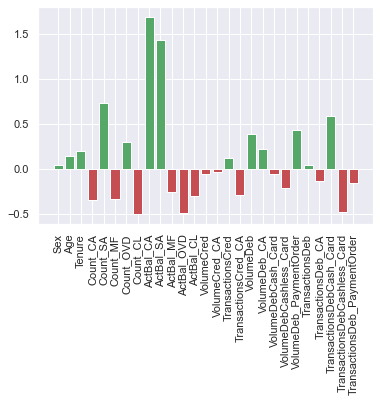

In [59]:
# feature importance code
    
importance = model_lr.named_steps['m'].coef_[0]
cols = list(X_train.columns)

# function to color the plot
def bar_color(df,color1,color2):
    return np.where(importance>0,color1,color2).T

# summarize feature importance
for col,score in zip(X_train.columns,importance):
    print('Feature: %0s, Score: %.5f' % (col,score))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color=bar_color(importance,'g','r'))
plt.xticks([x for x in range(len(importance))], cols, rotation=90)
plt.show()

We can see that for the given data set Logistic regression performed well when we changed the class weight. We will use this model for final prediction of sale of consumer loan.

In [60]:
# Saving model to disk for sale of consumer loan prediction
pickle.dump(model_lr, open('model_lr_sale_cc.pkl', 'wb'))

##### Applying Machine Learning Model

Applying Machine Learning model for regression problem and to find the revenue from the sale of consumer loan

In [61]:
#Splitting data set into train and test
# deviding the data set into target and predictors for regression problem
X_reg = df_train.copy()
X_reg.drop(['Client','Revenue_CC'],inplace = True, axis = 1)
# y_sale_cl = df_train.iloc[:,26].values
y_revenue_cl = df_train.iloc[:,29].values
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_revenue_cl, test_size=0.2, random_state=1)


In [62]:
model_evaluation(RandomForestRegressor(),scale = False,classification = False)

fit_time  score_time  test_neg_mean_squared_error  \
0  0.312512    0.000000                  -100.153387   
1  0.296886    0.015626                  -565.918898   
2  0.343765    0.000000                  -115.524630   
3  0.312512    0.000000                  -566.686336   
4  0.328142    0.000000                   -87.892520   
5  0.265641    0.015626                   -36.257171   
6  0.328146    0.000000                 -2245.454343   
7  0.312523    0.000000                  -372.406127   
8  0.296894    0.000000                  -173.929321   
9  0.312523    0.015623                   -55.023953   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                     -3.875944                        -10.007666  
1                     -4.035020                        -23.789050  
2                     -3.135566                        -10.748238  
3                     -6.062528                        -23.805175  
4                     -2.622482                         -9.375101  
5                     -1.938900                         -6.021393  
6                     -9.511128                        -47.386225  
7                     -6.275525                        -19.297827  
8                     -4.022004                        -13.188227  
9                     -2.062967                         -7.417813

In [63]:
model_evaluation(AdaBoostRegressor(),scale = False,classification = False)

fit_time  score_time  test_neg_mean_squared_error  \
0  0.156255    0.006002                  -137.671592   
1  0.155254    0.007002                  -551.342023   
2  0.154254    0.007003                   -36.432647   
3  0.161257    0.005997                  -525.192894   
4  0.159256    0.005999                   -73.096831   
5  0.157257    0.006998                  -118.957094   
6  0.159256    0.006999                 -2122.060173   
7  0.141631    0.006998                  -165.186684   
8  0.142630    0.006998                  -110.463631   
9  0.141631    0.004999                   -48.244496   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                     -8.781695                        -11.733354  
1                     -6.908528                        -23.480673  
2                     -4.715403                         -6.035946  
3                     -5.890704                        -22.917087  
4                     -5.804928                         -8.549668  
5                     -8.064095                        -10.906745  
6                    -13.500612                        -46.065824  
7                     -5.498812                        -12.852497  
8                     -5.108290                        -10.510168  
9                     -5.277930                         -6.945826

In [64]:
# import sklearn as sklearn
# sklearn.metrics.SCORERS.keys()

From the cross validation results we can see that Linear regression and random forest is performing well so we will do hyper-parameter tunning for this two algorithm and try to improve the model performance.

In [65]:
model_evaluation(Ridge(),scale = True,classification = False)

fit_time  score_time  test_neg_mean_squared_error  \
0  0.011005    0.003002                   -46.357064   
1  0.010005    0.003002                  -543.399482   
2  0.011004    0.003000                   -26.569731   
3  0.010005    0.003000                  -517.674310   
4  0.011001    0.003000                   -17.287018   
5  0.011003    0.002000                   -34.876081   
6  0.011001    0.002000                 -2087.005989   
7  0.011002    0.002001                  -143.373134   
8  0.010001    0.002000                   -91.630067   
9  0.010001    0.002000                   -18.101260   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                     -4.573395                         -6.808602  
1                     -4.870864                        -23.310931  
2                     -3.308091                         -5.154583  
3                     -5.643067                        -22.752457  
4                     -2.641112                         -4.157766  
5                     -3.289804                         -5.905597  
6                     -7.895326                        -45.683761  
7                     -4.833941                        -11.973852  
8                     -3.910317                         -9.572360  
9                     -2.854804                         -4.254558

We can see that out of all models Random forest and Ridge performed well so we will do hyper-parameter tunning for improving the model performance.


##### Random Forest Regression

In [66]:
# creating a parameter grid for cross validation and hyper parameter tuning
param_grid_rf = {
    'm__max_depth': [80, 90],
    'm__min_samples_leaf': [ 4, 5],
    'm__min_samples_split': [8, 10],
    'm__n_estimators': [50,100,150]
}
model = RandomForestRegressor()
Steps_rf = [ ('m', model)]
pipeline_rf = Pipeline(steps = Steps_rf)
grid_search_rf = GridSearchCV(estimator = pipeline_rf, param_grid = param_grid_rf,refit = 'neg_mean_absolute_error',scoring = ['neg_mean_absolute_error','neg_mean_squared_error'], cv = 10, n_jobs = -1, verbose = 2)  
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [67]:
grid_search_rf.fit(X_train_reg, y_train_reg)
grid_search_rf.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


{'m__max_depth': 90,
 'm__min_samples_leaf': 5,
 'm__min_samples_split': 8,
 'm__n_estimators': 50}

In [68]:
model_rf = grid_search_rf.best_estimator_

In [69]:
# predicting the values using X_test data set
y_pred_rf = model_rf.predict(X_test_reg)

In [70]:
# Calculating the metrics for our model performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_rf)))

Mean Absolute Error: 2.801201834461265
Mean Squared Error: 106.53606681095526
Root Mean Squared Error: 10.321631015055482


In [71]:
# Feature importance
cols_reg = list(X_train_reg.columns)
eli5.explain_weights(model_rf.named_steps['m'], top=15, feature_names=cols_reg)

Explanation(estimator='RandomForestRegressor(max_depth=90, min_samples_leaf=5, min_samples_split=8,\n                      n_estimators=50)', description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='Sale_CC', weight=0.2562176763624599, std=0.1064722900519452, value=None), FeatureWeight(feature='Tenure', weight=0.1879622669841922, std=0.25093023858194985, value=None), FeatureWeight(feature='VolumeDeb_PaymentOrder', weight=0.08998490939248699, std=0.1311458065815396, value=None), FeatureWeight(feature='Age', weight=0.06337089392273017, std=0.13390349286952777, value=None), FeatureWeight(feature='VolumeCred_CA', weight=0.05245979480527839, std=0.1278562809996344, value=None), FeatureWeight(feature='VolumeCred', weight=0.051316862730856866, std=0.12649487042832994, value=None), FeatureWeight(feature='TransactionsCred', weight=0.03873697454191298, std=0.08886372318414577, value=None), FeatureWeight(feature='ActBal_CA', weight=0.036594615599552315, std=0.0687270500775711, value=None), FeatureWeight(feature='TransactionsDebCash_Card', weight=0.0339668489156045, std=0.0984621294243766, value=None), FeatureWeight(feature='VolumeDeb', weight=0.03268078002215092, std=0.10350723806576827, value=None), FeatureWeight(feature='TransactionsCred_CA', weight=0.026502108544680256, std=0.08670881794090941, value=None), FeatureWeight(feature='TransactionsDeb_CA', weight=0.025822960291956205, std=0.08674572082304463, value=None), FeatureWeight(feature='Sex', weight=0.024705976585071482, std=0.0989054749216075, value=None), FeatureWeight(feature='TransactionsDeb_PaymentOrder', weight=0.0201968227884271, std=0.04958064683157365, value=None), FeatureWeight(feature='VolumeDebCashless_Card', weight=0.012244641755248371, std=0.07285577184453358, value=None)], remaining=13), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

##### Ridge Regression Algorithm

In [72]:
# creating a parameter grid for cross validation and hyper parameter tuning

param_grid_rd = {
    'm__alpha': arange(0, 1, 0.01)
    
}

model = Ridge()
Steps_rd = [ ('m', model)]
pipeline_rd = Pipeline(steps = Steps_rd)
grid_search_rd = GridSearchCV(estimator = pipeline_rd, param_grid = param_grid_rd,refit = 'neg_mean_absolute_error',scoring = ['neg_mean_absolute_error','neg_mean_squared_error'], cv = 10, n_jobs = -1, verbose = 2)  
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [73]:
grid_search_rd.fit(X_train_reg, y_train_reg)
grid_search_rd.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'m__alpha': 0.99}

In [74]:
model_rd = grid_search_rd.best_estimator_

In [75]:
# predicting the values using X_test data set
y_pred_rd = model_rd.predict(X_test_reg)

In [76]:
# Calculating the metrics for our model performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_rd))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_rd))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_rd)))

Mean Absolute Error: 3.647528693734944
Mean Squared Error: 87.6558686371254
Root Mean Squared Error: 9.362471288988042


In [77]:
# Feature Importance

eli5.explain_weights(model_rd.named_steps['m'], top=15, feature_names=cols_reg)

Explanation(estimator='Ridge(alpha=0.99)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='Sale_CC', weight=10.92125048334894, std=None, value=None), FeatureWeight(feature='Count_OVD', weight=3.2769115022377995, std=None, value=None), FeatureWeight(feature='TransactionsCred', weight=0.9927386763016185, std=None, value=None), FeatureWeight(feature='TransactionsDeb_CA', weight=0.4238708138615983, std=None, value=None), FeatureWeight(feature='TransactionsDebCash_Card', weight=0.26336995996747803, std=None, value=None), FeatureWeight(feature='TransactionsDeb_PaymentOrder', weight=0.051157643041457826, std=None, value=None), FeatureWeight(feature='TransactionsDebCashless_Card', weight=0.049805100051007765, std=None, value=None), FeatureWeight(feature='Count_MF', weight=0.02653387799781309, std=None, value=None)], neg=[FeatureWeight(feature='Count_CL', weight=-1.5122515786540134, std=None, value=None), FeatureWeight(feature='Sex', weight=-1.1985786327136392, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-1.0924219892251998, std=None, value=None), FeatureWeight(feature='Count_SA', weight=-1.0477723135853907, std=None, value=None), FeatureWeight(feature='TransactionsCred_CA', weight=-0.901248609739561, std=None, value=None), FeatureWeight(feature='Count_CA', weight=-0.4300954037044464, std=None, value=None), FeatureWeight(feature='TransactionsDeb', weight=-0.39360002219246665, std=None, value=None)], pos_remaining=5, neg_remaining=9), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [78]:
# Saving model to disk for revenue prediction
pickle.dump(model_rf, open('model_rf_revenue_cc.pkl', 'wb'))

## Predicting Sales and Revenue from Mutual Funds to New Data

##### First, Predicting the sales of mutual fund using Logistic regression

In [79]:
df_test = pd.read_excel("Data\df_test.xlsx",engine='openpyxl')

In [80]:
df_test_client = df_test["Client"]

In [81]:
df_test.drop(['Unnamed: 0','Client'],inplace = True,axis =1)

##### Pre-Processing steps that we performed on Training

In [82]:
# dropping columns
columns_sale_cc = ['Count_CC','ActBal_CC']
df_test.drop(columns_sale_cc,inplace = True,axis = 1)

In [83]:
# # replacing null values with U (Unknown) if any
df_test.Sex = df_test.Sex.replace(np.nan,"U",regex=True)

In [84]:
# converting M and F to 1 and 0
df_test.Sex = df_test.Sex.replace({'M':1, 'F':0,'U':2})

In [85]:
# imputing age with tenure + 120 months if tenure is more than Age
df_test.Age = np.where((df_test.Age *12 <= df_test.Tenure),round(df_test.Tenure/12) + 10,df_test.Age)

In [86]:
# imputing other null values with 0 in the data set
df_test.fillna(0,inplace = True)

In [87]:
col_test = df_test.columns
df_test.Age = df_test.Age.mask(df_test.Age <= 10)
df_test[col_test] = imputer.transform(df_test.values) 

In [88]:
y_pred_lr_cc = model_lr.predict(df_test)

In [89]:
# predicting the values using X_test data set
y_pred_lr_cc_prob = model_lr.predict_proba(df_test)

In [90]:
# y_pred_lr_mf[y_pred_lr_mf[:,1]>0.5][:,1]

In [91]:
df_test['Sale_CC'] = y_pred_lr_cc

In [92]:
y_pred_rf_cc = model_rf.predict(df_test)

In [93]:
df_pred_cc = pd.DataFrame({'Client':df_test_client,'ProbablitySaleCC':y_pred_lr_cc_prob[:,1].reshape(-1),'RevenueCC':y_pred_rf_cc.reshape(-1)})

In [94]:
df_pred_cc[df_pred_cc['ProbablitySaleCC'] >0.5]

Client  ProbablitySaleCC  RevenueCC
26     1289          0.514352  20.905908
52       19          0.672685   6.801990
68      633          0.598099  26.569713
78     1227          0.523352   9.316274
89      382          0.500293  10.231140
103    1414          0.972163  19.227021
120    1410          0.664099   8.955960
127    1419          0.547736   3.875425
209     352          0.804400   6.578219
242     389          0.590343   6.279656
253    1365          0.512100  41.782279
266    1077          0.611719  21.558499
269     505          0.516761   9.795827
282     853          0.526902   9.097953
285     951          0.643399  13.612368
286    1241          0.536520   4.528910
294     197          0.802965  23.321052
301     587          0.583514  12.123658
387    1260          0.517243   6.627830
400    1324          0.506285  11.800636
421    1455          0.518902  21.504553
436     813          0.522527   8.909093
439    1588          0.554437   5.936317
461     151          0.520646  27.749059
479     760          0.719409   8.750705
487    1112          0.517220   6.866002
494     488          0.518098  31.083746
495     206          0.546791  20.067108
503     886          0.619827  11.627358
507     851          0.602391   6.274969
512     340          0.512123   8.957127
534    1569          0.513366   8.294879
560    1487          0.561318   4.025975
574    1278          0.639742  23.259391
576     535          0.609640  10.570828
587     532          0.628073  15.328404
607    1491          0.510132  10.894118

In [105]:
df_pred = pd.read_excel("Data\df_pred.xlsx",engine='openpyxl')

In [106]:
df_pred = pd.merge(df_pred, df_pred_cc, how="left", on=["Client"])

In [107]:
df_pred.drop(['Unnamed: 0','Unnamed: 0.1'],inplace = True,axis =1)

In [108]:
with pd.ExcelWriter('Data\df_pred.xlsx',sheet_name="Sheet1",engine="openpyxl",mode='u') as writer:  
    df_pred.to_excel(writer)